In [1]:
import pandas as pd
import dgl
import dgl.data
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

df_players = pd.read_csv("./../data_scrapped/atp_players.csv")
df_matchs = pd.read_csv("./../data_formatted/training_dgl_dataset.csv")

In [3]:
#On construit le graph

# lecture des données attendues
# tensor1[1] -> tensor2[1] 
# le player index en tensor1 a battu le player au meme index en tensor 2

# le graph est directed : on n'indique que les victoires
# pour cette raison le shuffle n'a pas été exécuté sur le dataset

tensor1=[]
tensor2=[]

for index,row in df_players.iterrows():
    winmatchs = df_matchs[df_matchs.player1_id == row.player_id]
    #print(len(winmatchs))
    if len(winmatchs) > 0:
        #print(row.player_id)
        for index2, row2 in winmatchs.iterrows():
                tensor1.append(index)
                tensor2.append(df_players.loc[df_players.player_id == row2.player2_id].index[0])

In [17]:
list(df_players[["birth_year","weight_kg","height_cm"]].values)

[array([1995.,   nan]),
 array([1993.,   85.]),
 array([1991.,   85.]),
 array([1988.,   77.]),
 array([1979.,   79.]),
 array([1982.,   70.]),
 array([2000.,   nan]),
 array([1997.,   nan]),
 array([1974.,   90.]),
 array([1973.,   78.]),
 array([1990.,   78.]),
 array([1990.,   75.]),
 array([1983.,   74.]),
 array([nan, nan]),
 array([1988.,   97.]),
 array([1990.,   80.]),
 array([1990.,   nan]),
 array([1992.,   nan]),
 array([1997.,   80.]),
 array([1986.,    0.]),
 array([1994.,   81.]),
 array([1976.,   nan]),
 array([1994.,   80.]),
 array([1998.,   70.]),
 array([1984.,   88.]),
 array([1988.,   85.]),
 array([1980.,   nan]),
 array([1988.,   nan]),
 array([1990.,   83.]),
 array([1991.,   nan]),
 array([1972.,   73.]),
 array([1991.,   77.]),
 array([1973.,   66.]),
 array([1991.,   78.]),
 array([1998.,   81.]),
 array([2001.,   82.]),
 array([1981.,   nan]),
 array([1993.,   nan]),
 array([nan, nan]),
 array([1997.,   75.]),
 array([1997.,   85.]),
 array([1989.,   83.]),


In [4]:
# this create the player relationship
tennisgraph = dgl.graph((tensor1, tensor2))

# Adding node (=players) features
tennisgraph.ndata['x'] = torch.Tensor(list(df_players[["birth_year","weight_kg","height_cm"]].values))

# Adding edge (=matchs) features
tennisgraph.edata['x'] = torch.Tensor(list(df_matchs[["player1_atprank","player1_oddsB365","player2_atprank","player2_oddsB365"]].values))
tennisgraph.edata['y'] = torch.Tensor(list(df_matchs[["winner_player1"]].values))

## synthetic train-validation-test splits
# mask for edge 
tennisgraph.edata['train_mask'] =  torch.zeros(df_matchs.shape[0], dtype=torch.bool).bernoulli(0.6)

C:\Users\chbou\AppData\Local\Temp\ipykernel_15684\2256603712.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  tennisgraph.ndata['x'] = torch.Tensor(list(df_players[["birth_year","weight_kg","height_cm"]].values))


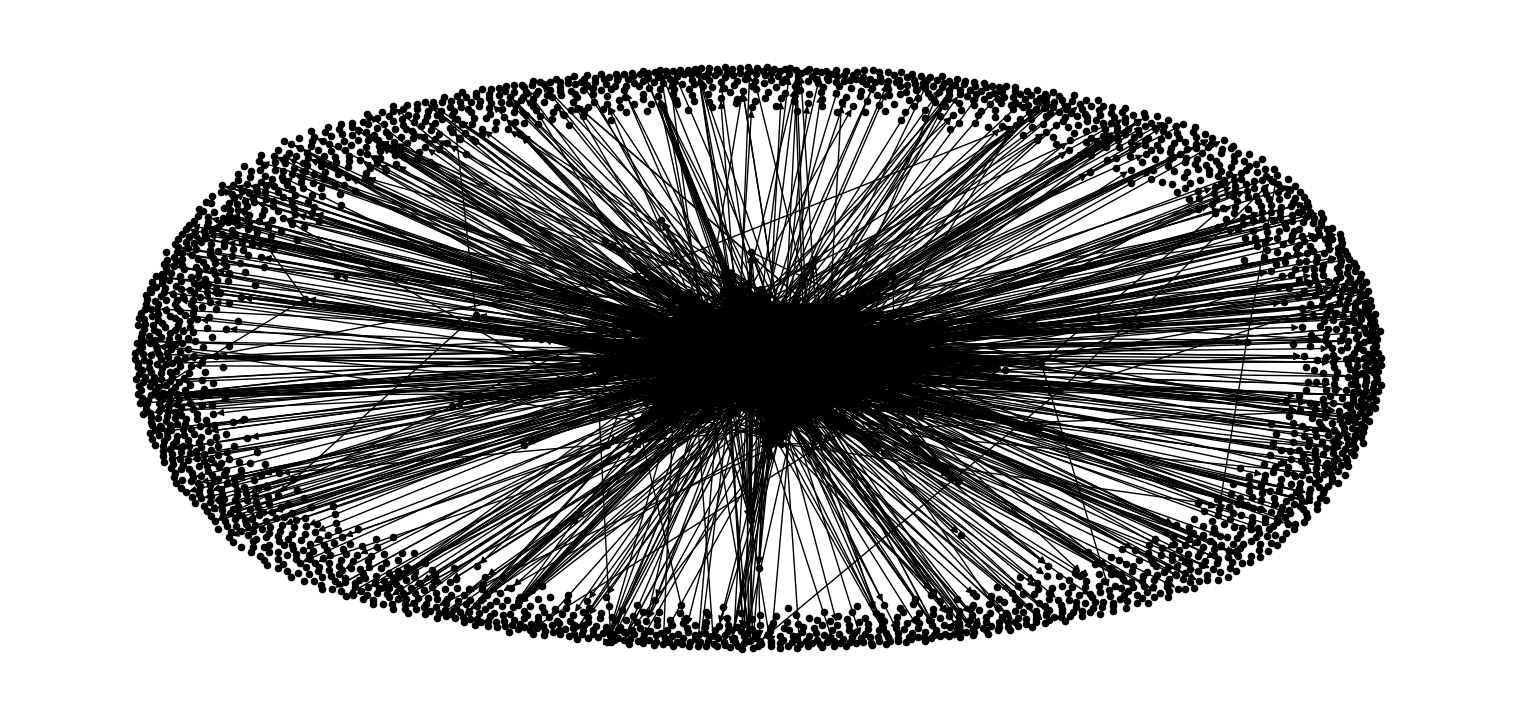

In [59]:
#display matchs and players although we see nothing :D
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(tennisgraph)
plt.figure(figsize=[15,7])
nx.draw(G, **options)

In [5]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            #graph.ndata['h'] = h
            #graph.apply_edges(fn.u_dot_v('x', 'x', 'score'))
            #graph.apply_edges(lambda edges: {'score' : edges.src['x'] + edges.dst['x']})
            graph.apply_edges(fn.u_add_v('h', 'h', 'm'))
            return graph.edata['m']

In [6]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [7]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [8]:
g = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4]))
g.ndata['h'] = torch.ones(5, 2)
g.apply_edges(lambda edges: {'x' : edges.src['h'] + edges.dst['h']})
g.edata['x']

tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]])

In [9]:
node_features = tennisgraph.ndata['x']
edge_label = tennisgraph.edata['y']
train_mask = tennisgraph.edata['train_mask']
model = Model(3, 20, 1)
opt = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(300):
     # Use all data as input, because all nodes have node features
    pred = model(tennisgraph, node_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

KeyError: 'h'